<a href="https://colab.research.google.com/github/hseyeon1006/ESAA_OB/blob/main/1120%EB%B0%9C%ED%91%9C_OB1%EC%A1%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[데이터 설명]

1. train_data.csv

├ Index : train data index

├ Premise : 실제 Text

├ Hypothesis : 가설 Text

└ Label : 참(Entailment) 또는 거짓(Contradiction) 또는 중립(Neutral)



*Premise와 Hypothesis의 관계를 추론



2. test_data.csv
├ Index : test data index

├ Premise : 실제 Text

├Hypothesis : 가설 Text

└Label : 추론해야 하는 Label 값



3. sample_submission.csv
├ Index : test data index

└Label : 추론해야 하는 Label 값

KoBERT
- 한국어에 대한 많은 사전학습이 이루어져 있음
- 감성 분석 시, 긍부정 뿐만 아니라 다중 분류 가능함

adamp optimizer
- 기울기 최적화 방법과 모멘텀 방법을 결합해서 최적화 성능 향상
- 각 매개변수마다 학습률을 조정하여 전역 최적점과 지역 최적점 사이의 균형 유지

작동원리
1. 모델의 가중치를 무작위로 초기화
2. 학습 데이터에서 미니배치 무작위 선택
3. 선택한 미니배치 이용해서 손실함수 계산
4. 손실함수 기울기 계산
5. 기울기 사용해서 가중치 업데이트
6. 단계들 반복하면서 전체 학습 데이터에 대해 가중치 업데이트

장점
- 빠름/ 성능 좋음
- 지역 최적점에 잘 안빠지고 전역 최적점 가까이 수렴

단점
- 메모리 사용 큼

###0. IMPORT PACKAGES & DATA LOAD

In [1]:
# optimizer로 adamp 사용
!pip install adamp

In [2]:
!pip install transformers

In [3]:
#import packages
import pandas as pd
import numpy as np
import os

import transformers
from transformers import AutoTokenizer, AdamW, RobertaForSequenceClassification
from transformers import get_linear_schedule_with_warmup

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm, tqdm_notebook

import random
import torch.backends.cudnn as cudnn

from sklearn.model_selection import StratifiedKFold

from adamp import AdamP

In [4]:
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

In [5]:
#drive mount
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [20]:
# klue-nli-dev 데이터 추가해서 train데이터셋으로 이용
train = pd.read_csv('/content/mydrive/MyDrive/Colab_Notebooks/학회 OB/프로젝트/데이터/한국어 문장 관계 분류/train_data.csv')
test = pd.read_csv('/content/mydrive/MyDrive/Colab_Notebooks/학회 OB/프로젝트/데이터/한국어 문장 관계 분류/test_data.csv')
submission = pd.read_csv('/content/mydrive/MyDrive/Colab_Notebooks/학회 OB/프로젝트/데이터/한국어 문장 관계 분류/sample_submission.csv')

###1. EDA

In [21]:
print(train.info(), end='\n\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       24998 non-null  int64 
 1   premise     24998 non-null  object
 2   hypothesis  24998 non-null  object
 3   label       24998 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


In [22]:
print('Train Columns: ', train.columns)
print('Test Columns: ', test.columns)

Train Columns:  Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')
Test Columns:  Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')


In [23]:
print('Train Label: ', train['label'].value_counts(), sep='\n', end='\n\n')
print('Test Label: ', test['label'].value_counts(), sep='\n')

Train Label: 
entailment       8561
contradiction    8489
neutral          7948
Name: label, dtype: int64

Test Label: 
answer    1666
Name: label, dtype: int64


In [24]:
print('Train Null: ', train.isnull().sum(), sep='\n', end='\n\n')
print('Test Null: ', test.isnull().sum(), sep='\n')

Train Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64

Test Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64


LABEL 분포

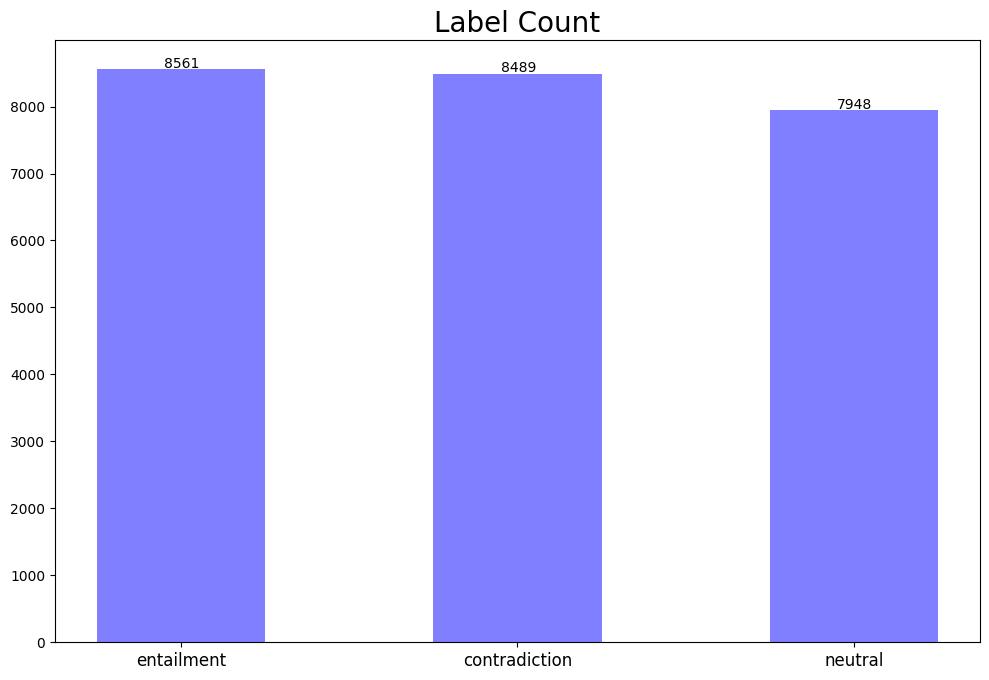

In [25]:
#Train Dataset의 Label 분포를 Bar Chart를 사용하여 시각화

feature = train['label']

plt.figure(figsize=(10,7.5))
plt.title('Label Count', fontsize=20)

temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
plt.text(-0.05, temp.values[0]+20, s=temp.values[0])
plt.text(0.95, temp.values[1]+20, s=temp.values[1])
plt.text(1.95, temp.values[2]+20, s=temp.values[2])

plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

전체, 가설 길이 확인

In [26]:
# Train에 존재하는 Premise(전제), Hypothesis(가설)의 길이를 확인하고 이를 통해 Tokenizer의 max_length 설정이 가능
max_len = np.max(train['premise'].str.len())
min_len = np.min(train['premise'].str.len())
mean_len = np.mean(train['premise'].str.len())

print('Max Premise Length: ', max_len)
print('Min Premise Length: ', min_len)
print('Mean Premise Lenght: ', mean_len, '\n')

max_len = np.max(train['hypothesis'].str.len())
min_len = np.min(train['hypothesis'].str.len())
mean_len = np.mean(train['hypothesis'].str.len())

print('Max Hypothesis Length: ', max_len)
print('Min Hypothesis Length: ', min_len)
print('Mean Hypothesis Lenght: ', mean_len)

Max Premise Length:  90
Min Premise Length:  19
Mean Premise Lenght:  45.406552524201935 

Max Hypothesis Length:  103
Min Hypothesis Length:  5
Mean Hypothesis Lenght:  24.924433954716378


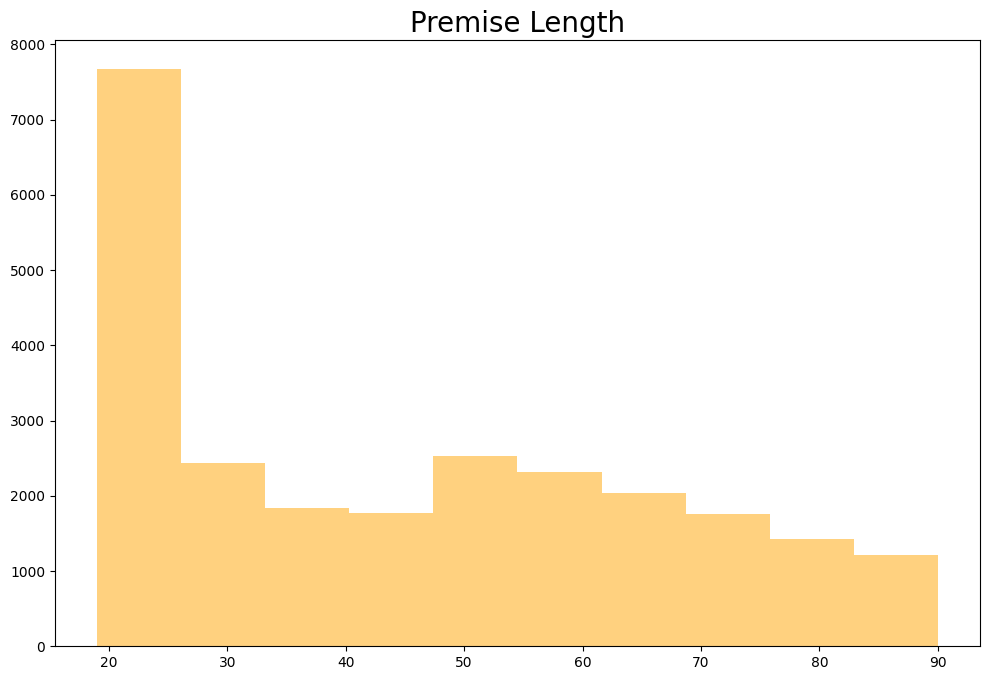

In [27]:
from collections import Counter

plt.figure(figsize=(10,7.5))
plt.title('Premise Length', fontsize=20)

plt.hist(train['premise'].str.len(), alpha=0.5, color='orange')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정

plt.show()

###3. MODEL2

In [6]:
# klue-nli-dev 데이터 추가해서 train데이터셋으로 이용
train_1 = pd.read_csv('/content/mydrive/MyDrive/Colab_Notebooks/학회 OB/프로젝트/데이터/한국어 문장 관계 분류/train_data.csv')
train_2 = pd.read_csv('/content/mydrive/MyDrive/Colab_Notebooks/학회 OB/프로젝트/데이터/klue_dev.csv')
test = pd.read_csv('/content/mydrive/MyDrive/Colab_Notebooks/학회 OB/프로젝트/데이터/한국어 문장 관계 분류/test_data.csv')
submission = pd.read_csv('/content/mydrive/MyDrive/Colab_Notebooks/학회 OB/프로젝트/데이터/한국어 문장 관계 분류/sample_submission.csv')

In [7]:
train=pd.concat([train_1, train_2])

In [8]:
train

,index,premise,hypothesis,label,Unnamed: 0
0,0.0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction,NaN
1,1.0,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction,NaN
2,2.0,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment,NaN
3,3.0,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral,NaN
4,4.0,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral,NaN
...,...,...,...,...,...
2989,NaN,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선을 넓히는 공사는 중단없이 마무리 되었다.,contradiction,2989.0
2990,NaN,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선을 넓히는 공사가 중단된 건 세 번째이다.,neutral,2990.0
2991,NaN,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선은 흔히 비자림로라고 불린다.,entailment,2991.0
2992,NaN,흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다.,비흡연자는 발코니 있는 방이 필요없습니다.,neutral,2992.0


In [9]:
# train, test데이터에 들어가는 변수들 다시 설정
list1 = [(train['label']== "entailment"), (train['label']== "contradiction"), (train['label']== "neutral")]
choicelist1 = [0,1,2]
train['label'] = np.select(list1, choicelist1)

train = train[['premise','hypothesis','label']]
test = test[['premise','hypothesis']]

In [10]:
# AutoTokenizer 클래스는 라이브러리에서 체크포인트 이름에 해당하는 토크나이저 클래스를 가져옴
# 라이브러리 내의 다른 모든 체크포인트와 함께 직접 사용가능

# 데이터가 bert모델의 입력으로 들어갈 수 있게 하기

class TRAINDataset(Dataset):

  # __init__ : 클래스를 생성할 때 실행되는 생성자
  def __init__(self, data):
    self.dataset = data
    self.tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

    print(self.dataset)

  def __len__(self):
    return len(self.dataset)

  # __getitem__ : 클래스의 인덱스에 접근할 때 자동으로 호출되는 메서드
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 0:3].values
    sentence1 = row[0]
    sentence2 = row[1]
    y = row[2]
    inputs = self.tokenizer(
        sentence1,
        sentence2,
        truncation=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        add_special_tokens=True,
        max_length=100
    )

    input_ids = torch.from_numpy(np.asarray(inputs['input_ids']))
    attention_mask = torch.from_numpy(np.asarray(inputs['attention_mask']))

    return input_ids, attention_mask, y

In [11]:
class TESTDataset(Dataset):

  def __init__(self, data):
    self.dataset = data
    self.tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

    print(self.dataset)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 0:2].values
    sentence1 = row[0]
    sentence2 = row[1]
    inputs = self.tokenizer(
        sentence1,
        sentence2,
        truncation=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        add_special_tokens=True,
        max_length=100
    )

    input_ids = torch.from_numpy(np.asarray(inputs['input_ids']))
    attention_mask = torch.from_numpy(np.asarray(inputs['attention_mask']))

    return input_ids, attention_mask

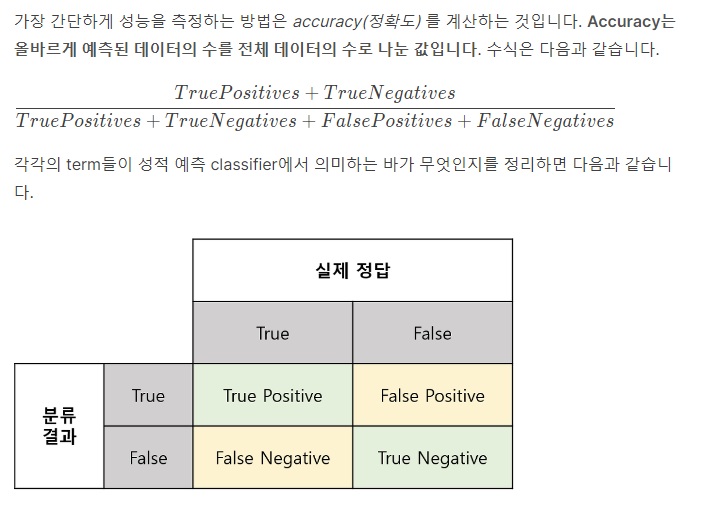

In [12]:
# 정확도 계산 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)

    # .data : 변수에서 값을 찾아줌
    # .cpu : gpu 메모리에 올라와있는 텐서를 cpu메모리로 복사해줌
    # .numpy : tensor를 numpy로 변환해줌
    # 가장 큰 값을 가지고 있는 인덱스가 레이블이랑 일치하는지 확인
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [13]:
# 파이토치에서 gpu 사용하기 위해서...
device = torch.device("cuda")

In [14]:
# 파라미터
epochs = 20
batch_size = 16

In [15]:
# 모델 학습 및 검증
def training(train_dataset,val_dataset, fold):
  best_acc = 0

  model = RobertaForSequenceClassification.from_pretrained("klue/roberta-large", num_labels=3).to(device)

  dataset_train = TRAINDataset(train_dataset)
  dataset_val = TRAINDataset(val_dataset)

  train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

  optimizer = AdamP(model.parameters(), lr=1e-5, betas=(0.9, 0.999), weight_decay=1e-2)

  total_steps = len(train_loader) * epochs

  # 스케줄러
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

  for e in range(epochs):
    train_acc = 0.0
    valid_acc = 0.0
    model.train()
    for batch_id, (token_ids, attention_masks, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
      optimizer.zero_grad()
      token_ids = token_ids.to(device)
      attention_masks = attention_masks.to(device)
      label = label.to(device)
      out = model(token_ids, attention_masks)[0]
      loss = F.cross_entropy(out, label)
      loss.backward()
      optimizer.step()
      scheduler.step()
      train_acc += calc_accuracy(out, label)

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    for batch_id, (token_ids, attention_masks, label) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
      token_ids = token_ids.to(device)
      attention_masks = attention_masks.to(device)
      label = label.to(device)
      out = model(token_ids, attention_masks)[0]
      valid_acc += calc_accuracy(out, label)
    print("epoch {} valid acc {}".format(e+1, valid_acc / (batch_id+1)))
#    if valid_acc > best_acc:
#      torch.save(model, '/content/drive/MyDrive/open/model'+str(fold)+'.pt')
    torch.save(model, '/content/mydrive/MyDrive/Colab_Notebooks/학회 OB/프로젝트/데이터/한국어 문장 관계 분류/model'+str(fold)+'.pt')

In [16]:
# 교차검증
def main():
    seed= 2021 # 재현성을 위한 시드값 고정
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.manual_seed(seed)  # type: ignore
    torch.backends.deterministic = True  # type: ignore
    torch.backends.benchmark = False  # type: ignore

    # kfold
    kfold=[]

    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
    for train_idx, val_idx in splitter.split(train.iloc[:, 0:2],train.iloc[:, 2]):
        kfold.append((train.iloc[train_idx,:],train.iloc[val_idx,:]))

    for fold,(train_datasets, valid_datasets) in enumerate(kfold):
        print(f'fold{fold} 학습중...')
        training(train_dataset=train_datasets,val_dataset=valid_datasets,fold=fold)

In [17]:
main() #학습 시작

fold0 학습중...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                premise  \
0     씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...   
1     삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...   
2                       이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.   
4     진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...   
5     이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...   
...                                                 ...   
2988                 후반부에 피클 통조림 따라고 따개를 챙겨준 독일 장교의 세심함   
2989  흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...   
2990  흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...   
2992                흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다.   
2993                흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다.   

                                   hypothesis  label  
0                              씨름의 여자들의 놀이이다.      1  
1                            자작극을 벌인 이는 3명이다.      1  
2     예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.      0  
4          이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.      2  
5         코오롱 인더

  0%|          | 0/1400 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
 28%|██▊       | 394/1400 [07:45<19:49,  1.18s/it]


KeyboardInterrupt: ignored

In [ ]:
# 예측
def inference(model, dataset_test):
    test_dataset = TESTDataset(dataset_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    output_pred = []
    with torch.no_grad():
      for batch_id, (token_ids, attention_masks) in tqdm(enumerate(test_loader), total=len(test_loader)):
        token_ids = token_ids.long().to(device)
        attention_masks = attention_masks.long().to(device)
        output=model(token_ids, attention_masks)[0]
        logits = torch.nn.functional.softmax(output, dim=1).detach().cpu().numpy()
        output_pred.extend(logits)
    return output_pred

In [ ]:
label_dict = {"entailment" : 0, "contradiction" : 1, "neutral" : 2}

In [ ]:
# 결과 도출
def inference_main():
  res = np.zeros((len(test),3))
  for i in range(5):
    print(f'fold{i} 모델 추론중...')
    # load my model
    model = torch.load('/content/drive/MyDrive/open/model'+str(i)+'.pt')

    pred_answer = inference(model, test)

    res += np.array(pred_answer) / 5

  ans= np.argmax(res, axis=-1)
  out = [list(label_dict.keys())[_] for _ in ans]
  submission["label"] = out

In [ ]:
inference_main()

In [ ]:
submission.to_csv("FOLD5(20)_submission.csv", index = False)